# LEO Satellite Link Budget Example

This notebook demonstrates how to create a complete link budget analysis for a Low Earth Orbit (LEO) satellite communication system using the PyRadio library. We'll analyze both:

1. **Forward Link (Uplink)**: Ground station to satellite at 2.075 GHz
2. **Return Link (Downlink)**: Satellite to ground station at 2.25 GHz

The parameters used in this example are based on typical values for small satellite communications.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

# Import PyRadio modules
from pyradio.antenna import Dish, FixedGain
from pyradio.link import Link
from pyradio.units import Q_, Hz, K, m, km, GHz, MHz, kHz

## Define Common Parameters

First, let's define some common parameters that will be used for both uplink and downlink calculations.

In [2]:
# Common parameters
distance = Q_(2000, 'km')  # Typical LEO satellite distance

# Create a function to return distance (allows for more complex models later)
def distance_function():
    return distance

# Implementation loss
uplink_implementation_loss = 2.0  # dB
downlink_implementation_loss = 0.5  # dB

# Required Eb/N0 for reliable communications
required_ebno = 9.6  # dB (typical for BPSK with BER 10^-6)

# Atmospheric loss function
def atmospheric_loss():
    return 0.3  # dB

# Pointing loss
pointing_loss = 1.0  # dB

# Polarization loss
polarization_loss = 0.5  # dB (will be calculated automatically by the Link class)

## Define Forward Link (Uplink) Parameters

Now let's define the parameters specific to the uplink from the ground station to the satellite.

In [3]:
# Uplink parameters
uplink_frequency = Q_(2.075, 'GHz')  # Uplink frequency
uplink_bandwidth = Q_(2.0, 'kHz')    # Uplink bandwidth (2 kbps data rate)

# Transmitter parameters (ground station)
tx_power_uplink = 20.0  # dBW (100W ground transmitter)
gs_dish_diameter = Q_(3.7, 'm')
gs_dish_efficiency = 0.65
gs_antenna = Dish(gs_dish_diameter, gs_dish_efficiency, axial_ratio=2.0)  # Slight elliptical polarization

# Receiver parameters (satellite)
sat_rx_antenna = FixedGain(-3.0, axial_ratio=3.0)  # Low-gain satellite receive antenna
sat_rx_system_noise_temp = Q_(290.0, 'K')  # Standard system temperature
sat_rx_antenna_noise_temp = Q_(200.0, 'K')  # Antenna picking up Earth

# Create the uplink object
uplink = Link(
    frequency=uplink_frequency,
    tx_antenna=gs_antenna,
    rx_antenna=sat_rx_antenna,
    tx_power=tx_power_uplink,
    rx_system_noise_temp=sat_rx_system_noise_temp,
    rx_antenna_noise_temp=sat_rx_antenna_noise_temp,
    distance_fn=distance_function,
    bandwidth=uplink_bandwidth,
    required_ebno=required_ebno,
    implementation_loss=uplink_implementation_loss,
    atmospheric_loss=atmospheric_loss
)

## Analyze Forward Link (Uplink) Budget

In [4]:
# Display the uplink budget
print("FORWARD LINK (UPLINK) BUDGET:")
print(uplink)

# Show specific parameters
print(f"\nLink Details:")
print(f"Frequency: {uplink_frequency.to('MHz'):.2f}")
print(f"Distance: {distance.to('km'):.2f}")
print(f"Bandwidth: {uplink_bandwidth.to('kHz'):.2f}")
print(f"\nGround Station TX:")
print(f"Transmit Power: {tx_power_uplink:.2f} dBW")
print(f"Dish Diameter: {gs_dish_diameter.to('m'):.2f}")
print(f"Antenna Gain: {gs_antenna.gain(uplink_frequency):.2f} dB")
print(f"\nSatellite RX:")
print(f"Antenna Gain: {sat_rx_antenna.gain(uplink_frequency):.2f} dB")
print(f"System Noise Temperature: {uplink.system_noise_temperature.to('K'):.2f}")

# Check if the link has sufficient margin
if uplink.margin > 3.0:
    print(f"\n✅ Forward link has adequate margin ({uplink.margin:.2f} dB)")
else:
    print(f"\n❌ Forward link may have insufficient margin ({uplink.margin:.2f} dB)")

FORWARD LINK (UPLINK) BUDGET:
Link Budget:
  EIRP: 56.2 dBW
  Path Loss: -164.5 dB
  Polarization Loss: 0.4 dB
  Received Power: -110.9 dBW
  System Noise Temperature: 490.0 K
  Noise Power: -168.7 dBW
  C/N: 57.8 dB
  Margin: 46.2 dB

Link Details:
Frequency: 2075.00 megahertz
Distance: 2000.00 kilometer
Bandwidth: 2.00 kilohertz

Ground Station TX:
Transmit Power: 20.00 dBW
Dish Diameter: 3.70 meter
Antenna Gain: 36.24 dB

Satellite RX:
Antenna Gain: -3.00 dB
System Noise Temperature: 490.00 kelvin

✅ Forward link has adequate margin (46.19 dB)


## Define Return Link (Downlink) Parameters

Now let's define the parameters specific to the downlink from the satellite to the ground station.

In [5]:
# Downlink parameters
downlink_frequency = Q_(2.25, 'GHz')    # Downlink frequency
downlink_bandwidth = Q_(2.0, 'MHz')     # Downlink bandwidth (higher for payload data)

# Transmitter parameters (satellite)
tx_power_downlink = 7.0  # dBW (5W satellite transmitter)
sat_tx_antenna = FixedGain(5.0, axial_ratio=3.0)  # Moderate gain satellite transmit antenna

# Receiver parameters (ground station) - using the same dish but at the downlink frequency
gs_rx_system_noise_temp = Q_(100.0, 'K')  # Low noise system
gs_rx_antenna_noise_temp = Q_(50.0, 'K')   # Antenna pointing to cold sky

# Create the downlink object
downlink = Link(
    frequency=downlink_frequency,
    tx_antenna=sat_tx_antenna,
    rx_antenna=gs_antenna,  # Same ground station antenna as used for uplink
    tx_power=tx_power_downlink,
    rx_system_noise_temp=gs_rx_system_noise_temp,
    rx_antenna_noise_temp=gs_rx_antenna_noise_temp,
    distance_fn=distance_function,
    bandwidth=downlink_bandwidth,
    required_ebno=required_ebno,
    implementation_loss=downlink_implementation_loss,
    atmospheric_loss=atmospheric_loss
)

## Analyze Return Link (Downlink) Budget

In [6]:
# Display the downlink budget
print("RETURN LINK (DOWNLINK) BUDGET:")
print(downlink)

# Show specific parameters
print(f"\nLink Details:")
print(f"Frequency: {downlink_frequency.to('MHz'):.2f}")
print(f"Distance: {distance.to('km'):.2f}")
print(f"Bandwidth: {downlink_bandwidth.to('MHz'):.2f}")
print(f"\nSatellite TX:")
print(f"Transmit Power: {tx_power_downlink:.2f} dBW")
print(f"Antenna Gain: {sat_tx_antenna.gain(downlink_frequency):.2f} dB")
print(f"\nGround Station RX:")
print(f"Dish Diameter: {gs_dish_diameter.to('m'):.2f}")
print(f"Antenna Gain: {gs_antenna.gain(downlink_frequency):.2f} dB")
print(f"System Noise Temperature: {downlink.system_noise_temperature.to('K'):.2f}")

# Check if the link has sufficient margin
if downlink.margin > 3.0:
    print(f"\n✅ Return link has adequate margin ({downlink.margin:.2f} dB)")
else:
    print(f"\n❌ Return link may have insufficient margin ({downlink.margin:.2f} dB)")

RETURN LINK (DOWNLINK) BUDGET:
Link Budget:
  EIRP: 12.0 dBW
  Path Loss: -165.2 dB
  Polarization Loss: 0.4 dB
  Received Power: -115.9 dBW
  System Noise Temperature: 150.0 K
  Noise Power: -143.8 dBW
  C/N: 27.9 dB
  Margin: 17.8 dB

Link Details:
Frequency: 2250.00 megahertz
Distance: 2000.00 kilometer
Bandwidth: 2.00 megahertz

Satellite TX:
Transmit Power: 7.00 dBW
Antenna Gain: 5.00 dB

Ground Station RX:
Dish Diameter: 3.70 meter
Antenna Gain: 36.94 dB
System Noise Temperature: 150.00 kelvin

✅ Return link has adequate margin (17.83 dB)


## Link Margin vs. Distance Analysis

Let's analyze how the link margin varies with distance for both uplink and downlink.

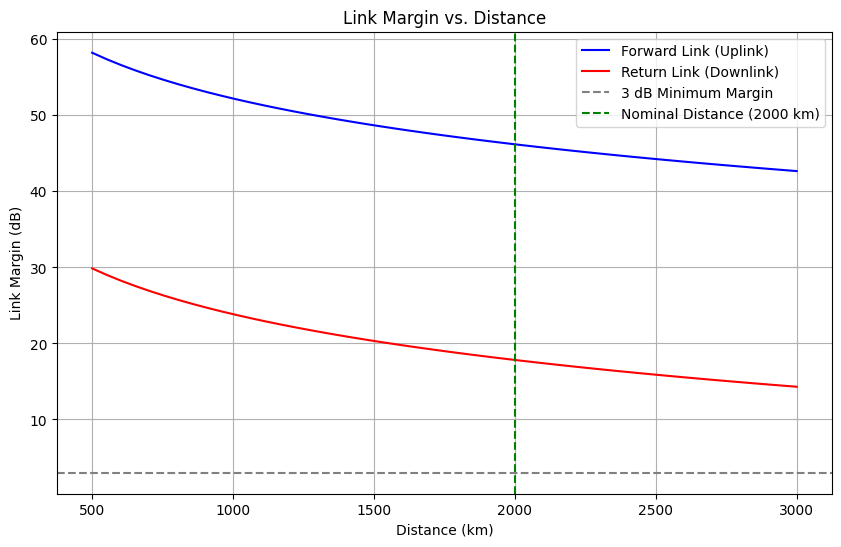

In [7]:
# Define a range of distances
distances = np.linspace(500, 3000, 50)  # km
uplink_margins = []
downlink_margins = []

# Calculate margins at each distance
for d in distances:
    # Update the distance
    distance = Q_(d, 'km')
    
    # Calculate margins
    uplink_margins.append(uplink.margin)
    downlink_margins.append(downlink.margin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(distances, uplink_margins, 'b-', label='Forward Link (Uplink)')
plt.plot(distances, downlink_margins, 'r-', label='Return Link (Downlink)')
plt.grid(True)
plt.xlabel('Distance (km)')
plt.ylabel('Link Margin (dB)')
plt.title('Link Margin vs. Distance')
plt.axhline(y=3, color='gray', linestyle='--', label='3 dB Minimum Margin')
plt.axvline(x=2000, color='green', linestyle='--', label='Nominal Distance (2000 km)')
plt.legend()
plt.show()

## BER vs. Eb/N0 Analysis

Let's analyze the Bit Error Rate (BER) as a function of Eb/N0 for the BPSK modulation used in our system.

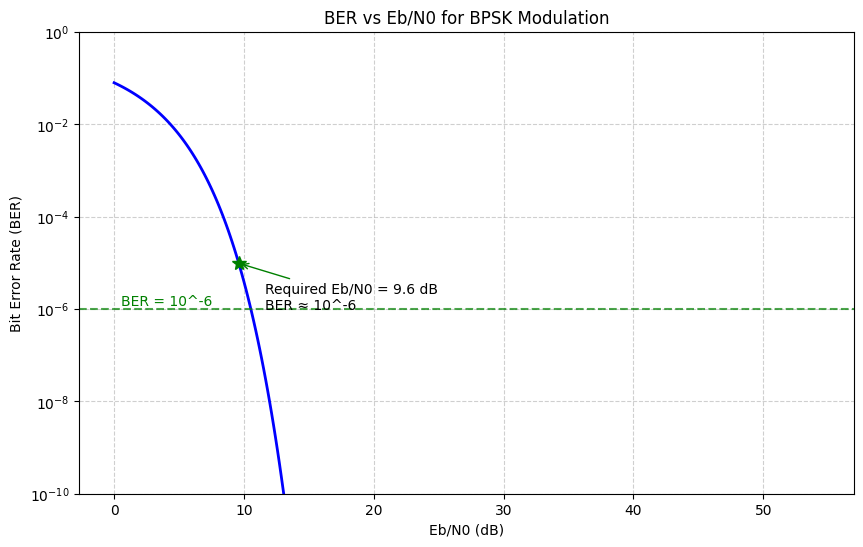

In [8]:
# Function to calculate BER for BPSK
def bpsk_ber(eb_n0_linear):
    return 0.5 * special.erfc(np.sqrt(eb_n0_linear))

# Create range of Eb/N0 values in dB
eb_n0_db_range = np.linspace(0, 15, 100)
# Convert to linear scale
eb_n0_linear_range = 10**(eb_n0_db_range/10)
# Calculate BER values
ber_values = bpsk_ber(eb_n0_linear_range)

# Plot BER vs Eb/N0
plt.figure(figsize=(10, 6))
plt.semilogy(eb_n0_db_range, ber_values, 'b-', linewidth=2)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs Eb/N0 for BPSK Modulation')

# Mark the operating points
# Uplink operating point
operating_point_ebno_uplink = uplink.ebno
operating_point_ber_uplink = bpsk_ber(10**(operating_point_ebno_uplink/10))
plt.plot(operating_point_ebno_uplink, operating_point_ber_uplink, 'bo', markersize=8)
plt.annotate(f'Uplink Eb/N0 = {operating_point_ebno_uplink:.1f} dB',
             xy=(operating_point_ebno_uplink, operating_point_ber_uplink), 
             xytext=(operating_point_ebno_uplink-8, operating_point_ber_uplink*100),
             arrowprops=dict(arrowstyle="->", color='blue'))

# Downlink operating point
operating_point_ebno_downlink = downlink.ebno
operating_point_ber_downlink = bpsk_ber(10**(operating_point_ebno_downlink/10))
plt.plot(operating_point_ebno_downlink, operating_point_ber_downlink, 'ro', markersize=8)
plt.annotate(f'Downlink Eb/N0 = {operating_point_ebno_downlink:.1f} dB',
             xy=(operating_point_ebno_downlink, operating_point_ber_downlink), 
             xytext=(operating_point_ebno_downlink+2, operating_point_ber_downlink*100),
             arrowprops=dict(arrowstyle="->", color='red'))

# Mark the required Eb/N0
required_ber = bpsk_ber(10**(required_ebno/10))
plt.plot(required_ebno, required_ber, 'g*', markersize=10)
plt.annotate(f'Required Eb/N0 = {required_ebno:.1f} dB\nBER ≈ 10^-6',
             xy=(required_ebno, required_ber), 
             xytext=(required_ebno+2, required_ber*0.1),
             arrowprops=dict(arrowstyle="->", color='green'))

plt.axhline(y=1e-6, color='g', linestyle='--', alpha=0.7)
plt.text(0.5, 1.2e-6, 'BER = 10^-6', color='g')

plt.ylim(1e-10, 1)
plt.show()

## Conclusion

This notebook demonstrated how to use the PyRadio library to analyze both uplink and downlink budgets for a LEO satellite communication system. Key findings include:

1. The forward link (uplink) has a substantial margin due to the high-power ground station transmitter and large dish antenna.
2. The return link (downlink) has a smaller but still adequate margin even with a much lower transmit power from the satellite.
3. The link margin decreases with increasing distance, but both links maintain adequate performance over the expected distance range of the LEO satellite.
4. The BER analysis confirms that both links exceed the required Eb/N0 for reliable communications with a BPSK modulation scheme.

This analysis provides confidence that the communication system design will meet the requirements for reliable satellite communications.